# Практическое задание №8 "Снижение размерности данных".

1. Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.
2. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline

In [2]:
rand_seed = 10

## Задание №1

Метод главных компонент (PCA):

1. _Центрировать_ матрицу $X$, т.е. вычесть из каждого столбца среднее по этому столбцу.
2. Найти собственные значения $\lambda_{1},...,\lambda_{n}$ матрицы несмещенных оценок ковариации $X^{T}X$, а также вычислить собственные вектора.
3. Отобрать $d$ максимальных собственных значения.
4. Составить матрицу $W_{pca}$, столбцы которой будут являться собственными векторами, соответствующими отобранным собственным значениям, расположенным в порядке убывания.
5. Получить новую матрицу "объекты-признаки" $Z$, умножив исходную матрицу $X$ на матрицу весов $W_{pca}$:

$$Z=XW_{pca}$$

Датасет IRIS и разбиение на train/test выборки:

In [3]:
X, y = load_iris(return_X_y=True)
X_train, y_train, X_labels, y_labels = model_selection.train_test_split(X, y, test_size=0.2, random_state=5)

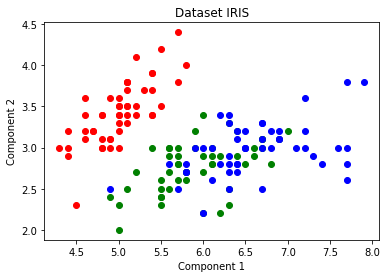

In [4]:
plt.figure()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X[y==i, 0], X[y==i, 1], c=c)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Dataset IRIS')
plt.show()

Построим 2 модели классификации (SGD, RF) на датасете IRIS __до применения PCA__:

In [5]:
model_sgd = SGDClassifier(alpha=0.001, max_iter=100, random_state=rand_seed)
model_sgd.fit(X_train, X_labels)
model_sgd_predictions = model_sgd.predict(y_train)

model_rf = RandomForestClassifier(n_estimators=100, random_state=rand_seed)
model_rf.fit(X_train, X_labels)
model_rf_predictions = model_rf.predict(y_train)

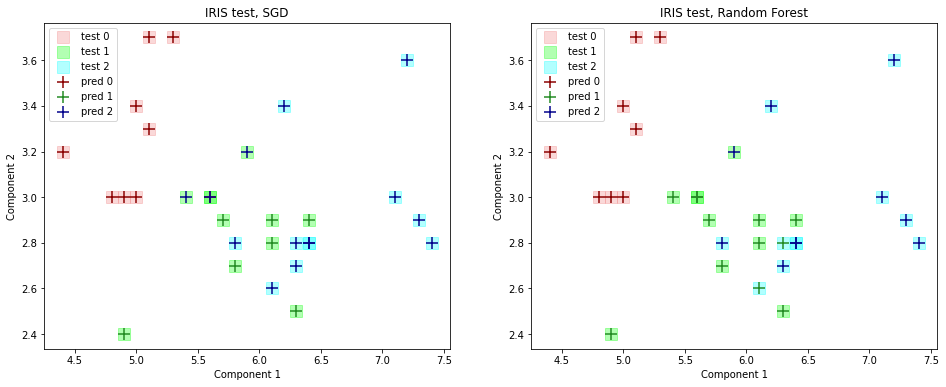

In [6]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train[y_labels==i, 0], y_train[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train[model_sgd_predictions==i, 0], y_train[model_sgd_predictions==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('IRIS test, SGD')    
    
plt.subplot(1,2,2)
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train[y_labels==i, 0], y_train[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train[model_rf_predictions==i, 0], y_train[model_rf_predictions==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('IRIS test, Random Forest') 

plt.show()

Построим модель классификации на датасете IRIS __после применения PCA__:

In [7]:
# Центрирование
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
y_train_std = scaler.transform(y_train)

In [8]:
# Матрица ковариаций
covariance_matrix = X_train_std.T.dot(X_train_std)

# Найдем собственные векторы и собственные значения
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# Cформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.51893356 -0.39329198]
 [-0.27008745 -0.91755812]
 [ 0.58021498 -0.02292767]
 [ 0.56666683 -0.05369213]]


In [9]:
X_train_pca = X_train_std.dot(W)
y_train_pca = y_train_std.dot(W)

In [10]:
model_sgd_pca = SGDClassifier(alpha=0.001, max_iter=100, random_state=rand_seed)
model_sgd_pca.fit(X_train_pca, X_labels)
model_sgd_predictions_pca = model_sgd_pca.predict(y_train_pca)

model_rf_pca = RandomForestClassifier(n_estimators=100, random_state=rand_seed)
model_rf_pca.fit(X_train_pca, X_labels)
model_rf_predictions_pca = model_rf_pca.predict(y_train_pca)

Сравнение:

* SGD

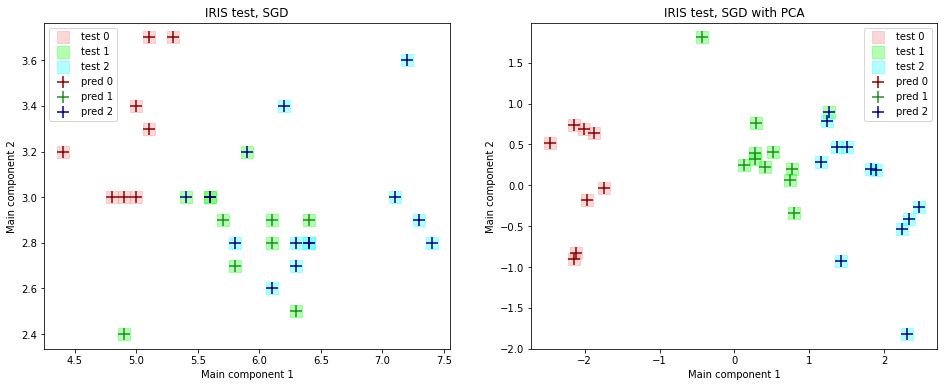

Result SGD:
              precision    recall  f1-score   support

           0      0.889     1.000     0.941         8
           1      1.000     0.636     0.778        11
           2      0.786     1.000     0.880        11

    accuracy                          0.867        30
   macro avg      0.892     0.879     0.866        30
weighted avg      0.892     0.867     0.859        30
Result SGD with PCA:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      1.000     0.909     0.952        11
           2      0.917     1.000     0.957        11

    accuracy                          0.967        30
   macro avg      0.972     0.970     0.970        30
weighted avg      0.969     0.967     0.967        30


In [11]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train[y_labels==i, 0], y_train[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train[model_sgd_predictions==i, 0], y_train[model_sgd_predictions==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, SGD')
    
plt.subplot(1,2,2)  
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train_pca[y_labels==i, 0], y_train_pca[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train_pca[model_sgd_predictions_pca==i, 0], y_train_pca[model_sgd_predictions_pca==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, SGD with PCA')
plt.show()

print('='*70)
print(f"Result SGD:\n{classification_report(y_labels, model_sgd_predictions, digits=3)}{'='*70}")
print(f"Result SGD with PCA:\n{classification_report(y_labels, model_sgd_predictions_pca, digits=3)}{'='*70}")

* Random Forest

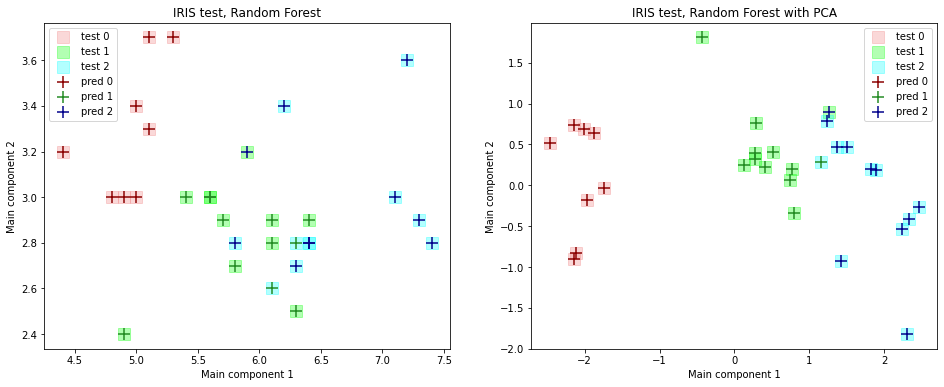

Result RF:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.833     0.909     0.870        11
           2      0.900     0.818     0.857        11

    accuracy                          0.900        30
   macro avg      0.911     0.909     0.909        30
weighted avg      0.902     0.900     0.900        30
Result RF with PCA:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.909     0.909     0.909        11
           2      0.909     0.909     0.909        11

    accuracy                          0.933        30
   macro avg      0.939     0.939     0.939        30
weighted avg      0.933     0.933     0.933        30


In [12]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train[y_labels==i, 0], y_train[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train[model_rf_predictions==i, 0], y_train[model_rf_predictions==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, Random Forest')
    
plt.subplot(1,2,2)  
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train_pca[y_labels==i, 0], y_train_pca[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train_pca[model_rf_predictions_pca==i, 0], y_train_pca[model_rf_predictions_pca==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, Random Forest with PCA')
plt.show()

print('='*70)
print(f"Result RF:\n{classification_report(y_labels, model_rf_predictions, digits=3)}{'='*70}")
print(f"Result RF with PCA:\n{classification_report(y_labels, model_rf_predictions_pca, digits=3)}{'='*70}")

__Вывод:__ 

* Алгоритм SGD: Благодаря PCA сократилось время на обучение и предсказание, а также повышено качество классификации. 

* Алгоритм Random Forest: Благодаря PCA сократилось время на обучение и предсказание, а также повышено качество классификации. 

Если сравнивать между алгоритмами, то значения качества в SGD при использовании PCA повысилось в более значительной степени.

## Задание №2

Сингулярное разложение (SVD):

1. Найти сингулярное разложение вектора $X$

$$X=UDV^{T}$$

2. Сформировать из столбцов матрицы $V$, соответствующих $d$ наибольшим сингулярным числам, матрицу весов $W$.

3. Получить новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

In [13]:
# Тренировочная выборка, которая центрирована. Это наш вектор Х, данный вектор будет учавствовать в обучении.
X_train_std[:5]

array([[-0.88140924,  0.7143396 , -1.23427138, -1.26819767],
       [-0.40389633, -1.69108967,  0.17471421,  0.16749781],
       [-0.16513988, -1.03506351, -0.10708291, -0.22405551],
       [-0.52327456,  1.37036577, -1.23427138, -1.26819767],
       [ 1.38677706,  0.27698883,  0.56923018,  0.29801558]])

Сделаем сингулярное разложение для вектора X:

In [14]:
U, s, W = np.linalg.svd(X_train_std)

# Транспонируем матрицу W
V = W.T

# s - список диагональных элементов, его нужно привести к виду диагональной матрицы для наглядности (D)
D = np.zeros_like(X_train_std, dtype=float)
D[np.diag_indices(min(X_train_std.shape))] = s
print(f"Диагональ матрицы D: {s}")

# Проведем проверку разложения
A = np.dot(np.dot(U, D), V.T)
diff = X_train_std - np.dot(np.dot(U, D), V.T)
print(f"Разница между разложением и Х: {np.round(np.sum(diff), 8)}")

Диагональ матрицы D: [18.72777408 10.52352674  4.02116048  1.53496944]
Разница между разложением и Х: -0.0


Веса для 4 признаков:

In [15]:
W

array([[ 0.51893356, -0.27008745,  0.58021498,  0.56666683],
       [-0.39329198, -0.91755812, -0.02292767, -0.05369213],
       [ 0.7151241 , -0.26599138, -0.1491245 , -0.62897376],
       [ 0.25421821, -0.11995188, -0.80036665,  0.52952608]])

Возьмем 2 признака, соответствующих наибольшим сингулярным числам. 

In [16]:
W = W[:,0:2]
print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.51893356 -0.27008745]
 [-0.39329198 -0.91755812]
 [ 0.7151241  -0.26599138]
 [ 0.25421821 -0.11995188]]


In [17]:
X_train_svd_pca = X_train_std.dot(W)
y_train_svd_pca = y_train_std.dot(W)

In [18]:
model_sgd_svd_pca = SGDClassifier(alpha=0.001, max_iter=100, random_state=rand_seed)
model_sgd_svd_pca.fit(X_train_svd_pca, X_labels)
model_sgd_svd_predictions_pca = model_sgd_svd_pca.predict(y_train_svd_pca)

model_rf_svd_pca = RandomForestClassifier(n_estimators=100, random_state=rand_seed)
model_rf_svd_pca.fit(X_train_svd_pca, X_labels)
model_rf_svd_predictions_pca = model_rf_svd_pca.predict(y_train_svd_pca)

Сравнение:

* SGD

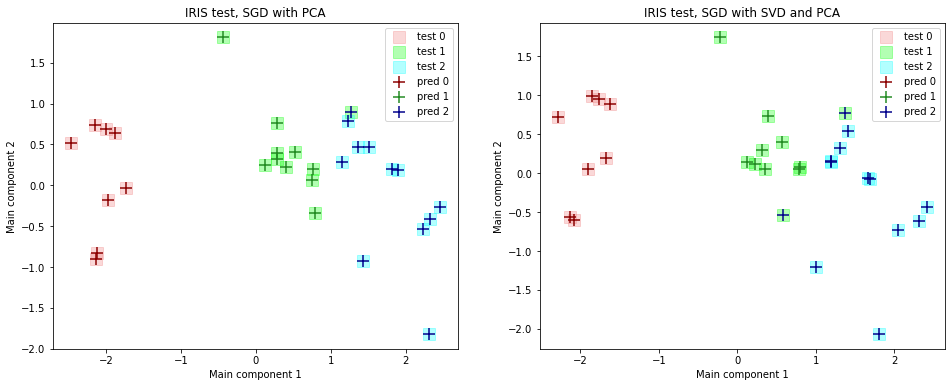

Result SGD with PCA:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      1.000     0.909     0.952        11
           2      0.917     1.000     0.957        11

    accuracy                          0.967        30
   macro avg      0.972     0.970     0.970        30
weighted avg      0.969     0.967     0.967        30
Result SGD with SVD and PCA:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      1.000     0.818     0.900        11
           2      0.846     1.000     0.917        11

    accuracy                          0.933        30
   macro avg      0.949     0.939     0.939        30
weighted avg      0.944     0.933     0.933        30


In [19]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)  
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train_pca[y_labels==i, 0], y_train_pca[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train_pca[model_sgd_predictions_pca==i, 0], y_train_pca[model_sgd_predictions_pca==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, SGD with PCA')

plt.subplot(1,2,2)  
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train_svd_pca[y_labels==i, 0], y_train_svd_pca[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train_svd_pca[model_sgd_svd_predictions_pca==i, 0], y_train_svd_pca[model_sgd_svd_predictions_pca==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, SGD with SVD and PCA')

plt.show()

print('='*70)
print(f"Result SGD with PCA:\n{classification_report(y_labels, model_sgd_predictions_pca, digits=3)}{'='*70}")
print(f"Result SGD with SVD and PCA:\n{classification_report(y_labels, model_sgd_svd_predictions_pca, digits=3)}{'='*70}")

* Random Forest

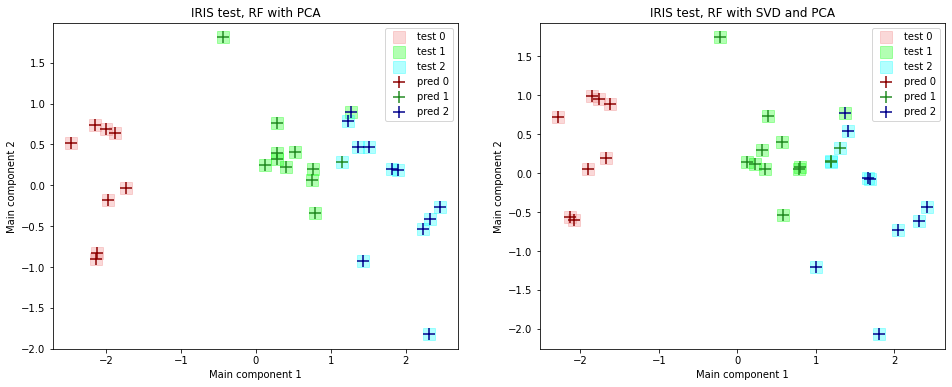

Result RF with PCA:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.909     0.909     0.909        11
           2      0.909     0.909     0.909        11

    accuracy                          0.933        30
   macro avg      0.939     0.939     0.939        30
weighted avg      0.933     0.933     0.933        30
Result RF with SVD and PCA:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.769     0.909     0.833        11
           2      0.889     0.727     0.800        11

    accuracy                          0.867        30
   macro avg      0.886     0.879     0.878        30
weighted avg      0.875     0.867     0.866        30


In [20]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)  
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train_pca[y_labels==i, 0], y_train_pca[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train_pca[model_rf_predictions_pca==i, 0], y_train_pca[model_rf_predictions_pca==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, RF with PCA')

plt.subplot(1,2,2)  
for c, i in zip(['lightcoral', 'lime', 'cyan'], [0, 1, 2]):
    plt.scatter(y_train_svd_pca[y_labels==i, 0], y_train_svd_pca[y_labels==i, 1], s=150, c=c, alpha = 0.3, marker='s', label=f'test {i}')
for c, i in zip(['darkred', 'forestgreen', 'darkblue'], [0, 1, 2]):
    plt.scatter(y_train_svd_pca[model_rf_svd_predictions_pca==i, 0], y_train_svd_pca[model_rf_svd_predictions_pca==i, 1], s=150, c=c, marker='+', label=f'pred {i}')
plt.xlabel('Main component 1')
plt.ylabel('Main component 2')
plt.legend()
plt.title('IRIS test, RF with SVD and PCA')

plt.show()

print('='*70)
print(f"Result RF with PCA:\n{classification_report(y_labels, model_rf_predictions_pca, digits=3)}{'='*70}")
print(f"Result RF with SVD and PCA:\n{classification_report(y_labels, model_rf_svd_predictions_pca, digits=3)}{'='*70}")

__Вывод:__

При использовании PCA с SVD качество снизилось по сравнению с моделями без использования SVD. Однако, значения качества получились всё равно лучше по сравнению с моделями без использования PCA.

---